✅ Workflow Plan:
* Step 1: Load and explore the dataset.
* Step 2: Preprocessing + add <start> and <end> tokens.
* Step 3: Tokenization (with <OOV> handling).
* Step 4: Padding and sequence preparation.
* Step 5: Model 1 — Seq2Seq encoder-decoder model setup.
* Step 6: Training + loss plots.
* Step 7: Model 2 — Transformer-style seq2seq setup.
* Step 8: Training + loss plots.
* Step 9: Inference testing on unseen data.

## STEP 1: Load & Explore Dataset

---



In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt

# Path to your dataset (adjust if needed)
file_path = '/content/drive/MyDrive/MT_Data/english-arabic-dataset.txt'

# Load first 10,000 lines
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()[:10000]

print(f"Total samples loaded: {len(lines)}")

Total samples loaded: 10000


In [4]:

# Corrected dataset loading
eng_sentences = []
arb_sentences = []

for line in lines:
    try:
        eng, arb = line.strip().split('\t')  # Correct splitting by tab
        eng_sentences.append(eng)
        arb_sentences.append(arb)
    except ValueError:
        continue

# Print 5 samples
for i in range(5):
    print(f"ENGLISH: {eng_sentences[i]}")
    print(f"ARABIC : {arb_sentences[i]}")
    print('---')


ENGLISH: Hi.
ARABIC : مرحبًا.
---
ENGLISH: Run!
ARABIC : اركض!
---
ENGLISH: Help!
ARABIC : النجدة!
---
ENGLISH: Jump!
ARABIC : اقفز!
---
ENGLISH: Stop!
ARABIC : قف!
---


In [5]:
# Sentence length analysis
eng_lengths = [len(sentence.split()) for sentence in eng_sentences]
arb_lengths = [len(sentence.split()) for sentence in arb_sentences]

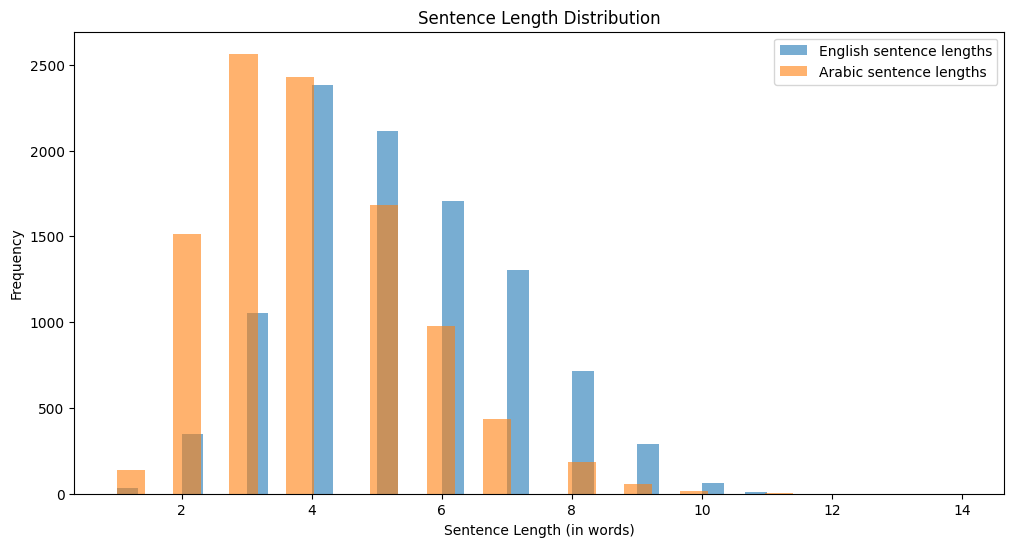

In [6]:
# Plot distributions
plt.figure(figsize=(12,6))
plt.hist(eng_lengths, bins=30, alpha=0.6, label='English sentence lengths')
plt.hist(arb_lengths, bins=30, alpha=0.6, label='Arabic sentence lengths')
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length (in words)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [7]:
# Check max lengths
print(f"Max English sentence length: {max(eng_lengths)}")
print(f"Max Arabic sentence length: {max(arb_lengths)}")

Max English sentence length: 11
Max Arabic sentence length: 14


## STEP 2: Preprocessing + Adding <start>, <end> Tokens

---


*   Lowercase
*   Strip whitespace
*   Remove punctuation
*   Remove digits if any
*   Remove double spaces
*   Start and end tokens added only on Arabic sentences.


In [8]:
# Function to clean and add special tokens
import re

def clean_sentence(sentence):
    # Lowercase
    sentence = sentence.lower().strip()
    # Remove punctuation and digits
    sentence = re.sub(r"[^a-zA-Zء-ي\s]", "", sentence)  # keeps Arabic & English letters and spaces only
    # Remove extra spaces
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    return sentence

def preprocess_arabic(sentence):
    sentence = clean_sentence(sentence)
    sentence = f"<start> {sentence} <end>"
    return sentence

def preprocess_english(sentence):
    sentence = clean_sentence(sentence)
    return sentence

# Apply cleaning
eng_sentences_cleaned = [preprocess_english(sent) for sent in eng_sentences]
arb_sentences_cleaned = [preprocess_arabic(sent) for sent in arb_sentences]

# Sanity check
for i in range(5):
    print(f"ENGLISH: {eng_sentences_cleaned[i]}")
    print(f"ARABIC : {arb_sentences_cleaned[i]}")
    print("---")

ENGLISH: hi
ARABIC : <start> مرحبا <end>
---
ENGLISH: run
ARABIC : <start> اركض <end>
---
ENGLISH: help
ARABIC : <start> النجدة <end>
---
ENGLISH: jump
ARABIC : <start> اقفز <end>
---
ENGLISH: stop
ARABIC : <start> قف <end>
---


## STEP 3: Tokenization with OOV handling and padding

---


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# English tokenizer
eng_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
eng_tokenizer.fit_on_texts(eng_sentences_cleaned)
eng_tensor = eng_tokenizer.texts_to_sequences(eng_sentences_cleaned)
#eng_tensor = tf.keras.preprocessing.sequence.pad_sequences(eng_tensor, padding='post')
eng_tensor = tf.keras.preprocessing.sequence.pad_sequences(eng_tensor, padding='post')

# Arabic tokenizer
arb_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
arb_tokenizer.fit_on_texts(arb_sentences_cleaned)
arb_tensor = arb_tokenizer.texts_to_sequences(arb_sentences_cleaned)
#arb_tensor = tf.keras.preprocessing.sequence.pad_sequences(arb_tensor, padding='post')

# Pad the sequences to have a uniform shape before finding max length
arb_tensor = tf.keras.preprocessing.sequence.pad_sequences(arb_tensor, padding='post') # This line is modified

# Find max lengths
english_vocab_size = len(eng_tokenizer.word_index) + 1
arabic_vocab_size = len(arb_tokenizer.word_index) + 1
max_eng_len = eng_tensor.shape[1]
max_ar_len = arb_tensor.shape[1]

print(f"English vocab size: {english_vocab_size}")
print(f"Arabic vocab size: {arabic_vocab_size}")

English vocab size: 3579
Arabic vocab size: 8773


note : max length was 14 + 2 = 16

In [10]:
# Pad sequences
#eng_tensor = pad_sequences(eng_tensor, maxlen=max_eng_len, padding='post')
#arb_tensor = pad_sequences(arb_tensor, maxlen=max_ar_len, padding='post')

# Sanity check: print example
for i in range(3):
    print(f"English sequence: {eng_tensor[i]}")
    print(f"Arabic sequence: {arb_tensor[i]}")
    print("---")

print("Tokenization & padding step done bestie!")

English sequence: [874   0   0   0   0   0   0   0   0   0   0]
Arabic sequence: [  2 773   3   0   0   0   0   0   0   0   0   0   0   0   0   0]
---
English sequence: [292   0   0   0   0   0   0   0   0   0   0]
Arabic sequence: [   2 2354    3    0    0    0    0    0    0    0    0    0    0    0
    0    0]
---
English sequence: [55  0  0  0  0  0  0  0  0  0  0]
Arabic sequence: [  2 900   3   0   0   0   0   0   0   0   0   0   0   0   0   0]
---
Tokenization & padding step done bestie!


## STEP 4 : Prepare training and validation sets

---


### Data Split -  MADE 75%

In [11]:
from sklearn.model_selection import train_test_split

split_ratio = 0.75
split_index = int(len(eng_tensor) * split_ratio)

english_train, english_val = eng_tensor[:split_index], eng_tensor[split_index:]
arabic_train, arabic_val = arb_tensor[:split_index], arb_tensor[split_index:]

print(f"English train shape: {english_train.shape}")
print(f"English val shape: {english_val.shape}")
print(f"Arabic train shape: {arabic_train.shape}")
print(f"Arabic val shape: {arabic_val.shape}")


English train shape: (7500, 11)
English val shape: (2500, 11)
Arabic train shape: (7500, 16)
Arabic val shape: (2500, 16)


## Step 5: LSTM Seq2Seq Model


---



### Seq2Seq with RNN-based encoder-decoder

* Static LR = 0.0005

* Add ReduceLROnPlateau with factor=0.5, patience=3

* Add EarlyStopping with patience=5

* Train for max 50 epochs -- early stop/ just an upper limit  

* Batch size 64


2ND APPROACH
   
*   Add Dropout layers (with rates between 0.3–0.5)

* Add L2 weight regularization

* Use LearningRateScheduler to fine-tune

* Reduce batch size from 64 to something like 32

3RD AOOROACH

* Recurrent dropout & L2 regularization
* Reduced LSTM units
* Gradient clipping in the optimizer
* Learning rate scheduler callback


4RTH APROACH
* Try reducing LSTM AGAIN

* Stronger L2 regularization

* Dropout after embeddings

* Gaussian noise for extra regularization

* Early stopping with more patience

In [12]:
embedding_dim = 64
lstm_units = 128

In [13]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, GaussianNoise, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [14]:
def scheduler(epoch, lr):
  if epoch < 8:
    return lr
  else:
    return lr * tf.math.exp(-0.1).numpy() # Convert Tensor to float using .numpy()
lr_scheduler = LearningRateScheduler(scheduler)

# Custom loss function that ignores padding (zeros)
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [15]:
from tensorflow.keras.layers import Masking

# Encoder
encoder_inputs = tf.keras.Input(shape=(None,))
encoder_embed = Embedding(english_vocab_size, embedding_dim)(encoder_inputs)
encoder_embed = Dropout(0.3)(encoder_embed)  # Add dropout after embeddings
encoder_lstm = LSTM(lstm_units, return_state=True, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(1e-4))
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embed)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = tf.keras.Input(shape=(None,))
decoder_embed = Embedding(arabic_vocab_size, embedding_dim)(decoder_inputs)
decoder_embed = Dropout(0.3)(decoder_embed)  # Dropout on decoder embeddings
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(1e-4))
decoder_outputs, _, _ = decoder_lstm(decoder_embed, initial_state=encoder_states)
decoder_dense = Dense(arabic_vocab_size, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [16]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=4, min_lr=1e-6)

In [17]:
# Prepare data for decoder
train_arb_in = arabic_train[:, :-1]
train_ar_out = arabic_train[:, 1:]
val_ar_in = arabic_val[:, :-1]
val_ar_out = arabic_val[:, 1:]

In [18]:
print(f"English train shape: {english_train.shape}")
print(f"English val shape: {english_val.shape}")
print(f"Arabic train input shape: {train_arb_in.shape}")
print(f"Arabic train output shape: {train_ar_out.shape}")

English train shape: (7500, 11)
English val shape: (2500, 11)
Arabic train input shape: (7500, 15)
Arabic train output shape: (7500, 15)


In [19]:
def predict_translation(input_sentence):
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_eng_len, padding='post')

    # Encode input
    states_value = encoder_model.predict(input_seq)  # Extract states from trained encoder

    # Decoder initial input
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = arb_tokenizer.word_index['<start>']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = arb_tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_ar_len:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence

## STEP 6: Train LSTM Model

---



In [20]:
history = model.fit([english_train, train_arb_in], train_ar_out,
                    validation_data=([english_val, val_ar_in], val_ar_out),
                    batch_size=32, epochs=5, callbacks=[early_stop, reduce_lr])


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.6713 - loss: 5.3596 - val_accuracy: 0.5707 - val_loss: 3.3342 - learning_rate: 5.0000e-04
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.7427 - loss: 2.1047 - val_accuracy: 0.6370 - val_loss: 3.1328 - learning_rate: 5.0000e-04
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.7664 - loss: 1.9568 - val_accuracy: 0.6410 - val_loss: 3.0615 - learning_rate: 5.0000e-04
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - accuracy: 0.7712 - loss: 1.8806 - val_accuracy: 0.6404 - val_loss: 3.0319 - learning_rate: 5.0000e-04
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.7697 - loss: 1.8394 - val_accuracy: 0.6429 - val_loss: 2.9815 - learning_rate: 5.0000e-04


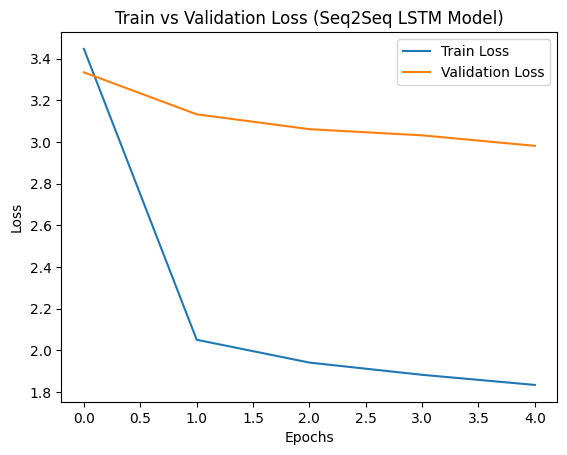

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss (Seq2Seq LSTM Model)')
plt.show()

# Model 2 — Transformer-style Seq2Seq Setup


---



---




## STEP 7: Transformer Model Functions


---







In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LayerNormalization, Dropout
import numpy as np

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [23]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


## STEP8: Build Transformer Model

---



In [24]:
# Model Parameters
embed_dim = 128  # Embedding size
num_heads = 8  # Number of attention heads
ff_dim = 512  # Feed forward layer size
max_len = 16  # Sentence max length (same as Seq2Seq model)

# Define Encoder
encoder_inputs = tf.keras.Input(shape=(None,))
embedding_layer = TokenAndPositionEmbedding(max_len, english_vocab_size, embed_dim)
x = embedding_layer(encoder_inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=False) # Pass training=False during model building
encoder_outputs = LayerNormalization(epsilon=1e-6)(x)

# Define Decoder
decoder_inputs = tf.keras.Input(shape=(None,))
decoder_embedding = TokenAndPositionEmbedding(max_len, arabic_vocab_size, embed_dim)
dec_x = decoder_embedding(decoder_inputs)
dec_x = transformer_block(dec_x, training=False) # Pass training=False here as well
decoder_outputs = Dense(arabic_vocab_size, activation="softmax")(dec_x)

# Define Full Transformer Model
transformer_model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
transformer_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
transformer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │      1,124,992 │ input_layer_4[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block         │ (None, None, 128)      │        659,712 │ token_and_position_em… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, None, 8773)     │      1,131,717 │ transformer_block[1][… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,916,421 (11.13 MB)

 Trainable params: 2,916,421 (11.13 MB)

 Non-trainable params: 0 (0.00 B)

##  Training the Transformer Seq2Seq Model

* Optimizer = Adam
* Loss = Sparse categorical crossentropy (matching integer-encoded targets)
* Trimmed decoder input + shifted decoder target setup
* Plots for visualizing training

In [25]:
# Training
train_ar_in = arabic_train[:, :-1]
train_ar_out = arabic_train[:, 1:]
val_ar_in = arabic_val[:, :-1]
val_ar_out = arabic_val[:, 1:]

history = transformer_model.fit(
    [english_train, train_ar_in], train_ar_out,
    validation_data=([english_val, val_ar_in], val_ar_out),
    batch_size=64, epochs=20, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.6882 - loss: 4.6153 - val_accuracy: 0.6489 - val_loss: 2.8717
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7826 - loss: 1.6049 - val_accuracy: 0.6749 - val_loss: 2.6766
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8128 - loss: 1.3050 - val_accuracy: 0.7048 - val_loss: 2.4547
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8495 - loss: 0.9997 - val_accuracy: 0.7209 - val_loss: 2.3688
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8837 - loss: 0.7473 - val_accuracy: 0.7416 - val_loss: 2.1891
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9170 - loss: 0.5279 - val_accuracy: 0.7727 - val_loss: 1.9493
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9507 - loss: 0.3340 - val_accuracy: 0.8065 - val_loss: 1.7256
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9753 - loss: 0.1955 - val_acc

## STEP 9:  Train Transformer Model

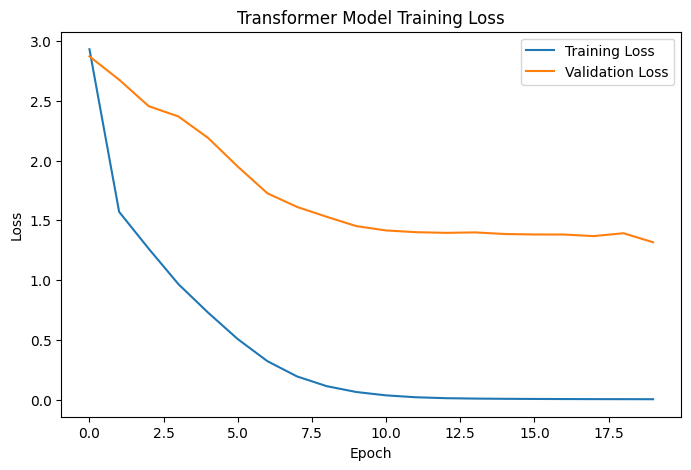

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## FINAL: Inference Testing on Unseen Data

---



---



In [37]:
def predict_translation_transformer(input_sentence, transformer_model, eng_tokenizer, arb_tokenizer, max_eng_len, max_ar_len):
    """
    Predicts the Arabic translation of an English sentence using the trained Transformer model.

    Args:
        input_sentence (str): The English sentence to translate.
        transformer_model (tf.keras.Model): The trained Transformer model.
        eng_tokenizer (tf.keras.preprocessing.text.Tokenizer): The English tokenizer.
        arb_tokenizer (tf.keras.preprocessing.text.Tokenizer): The Arabic tokenizer.
        max_eng_len (int): Maximum length of English sentences.
        max_ar_len (int): Maximum length of Arabic sentences.

    Returns:
        str: The predicted Arabic translation.
    """
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_eng_len, padding='post')

    # Decoder initial input
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = arb_tokenizer.word_index['<start>']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Get decoder output from the Transformer model
        # Pass input_seq and target_seq as inputs to the model directly
        output_tokens = transformer_model.predict([input_seq, target_seq])

        # Get the predicted word index
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Get the corresponding word
        sampled_word = arb_tokenizer.index_word.get(sampled_token_index, '')

        # Check for stopping condition
        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_ar_len:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update target sequence for next prediction
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return decoded_sentence.strip() # Remove leading/trailing spaces

In [38]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
# prompt: test several sentences

sentences_to_test = [
    "Hello, how are you?",
    "What is your name?",
    "The cat is sitting on the mat.",
    "I am learning machine translation.",
    "This is a test sentence."
]

for sentence in sentences_to_test:
    translated_sentence = predict_translation_transformer(
        sentence, transformer_model, eng_tokenizer, arb_tokenizer, max_eng_len, max_ar_len
    )
    print(f"English: {sentence}")
    print(f"Predicted Arabic: {translated_sentence}")
    print("---")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
English: Hello, how are you?
Predicted Arabic: سأقرر سأقرر سأقرر سأقرر سأقرر سأقرر سأقرر سأقرر سأقرر سأقرر سأقرر سأقرر سأقرر سأقرر سأقرر سأقرر سأقرر
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━